## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

2) The log marginal likelihood of the training data. (5 pts)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)


In [295]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel,RationalQuadratic,Exponentiation,ExpSineSquared,Matern, PairwiseKernel, RationalQuadratic, DotProduct
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
%pylab inline
import seaborn as sns
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

Populating the interactive namespace from numpy and matplotlib


In [10]:
import pandas as pd
import numpy as np
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


In [11]:
Data1['AvgDailyTrafficCount'] = np.log(Data1['AvgDailyTrafficCount'])

In [12]:
Data1['AvgDailyTrafficCount'] -= Data1['AvgDailyTrafficCount'].mean()

In [13]:
X = np.array(Data1.drop('AvgDailyTrafficCount',1))
y = Data1.AvgDailyTrafficCount.values.reshape(-1,1)

In [14]:
kernel = 0.1**2* RBF(length_scale=(0.01, 0.01), length_scale_bounds=(1e-3, 1e3)) \
    + WhiteKernel(noise_level=0.1**2,noise_level_bounds=(1e-10, 1e10)) + 1e-2 

gp = GaussianProcessRegressor(kernel=kernel,random_state=1)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)
y_pred, sigma = gp.predict(X, return_std=True)

print gp.log_marginal_likelihood_value_
print gp.kernel_

-1363.84361182
0.647**2 * RBF(length_scale=[0.0323, 0.0393]) + WhiteKernel(noise_level=0.568) + 0.179**2


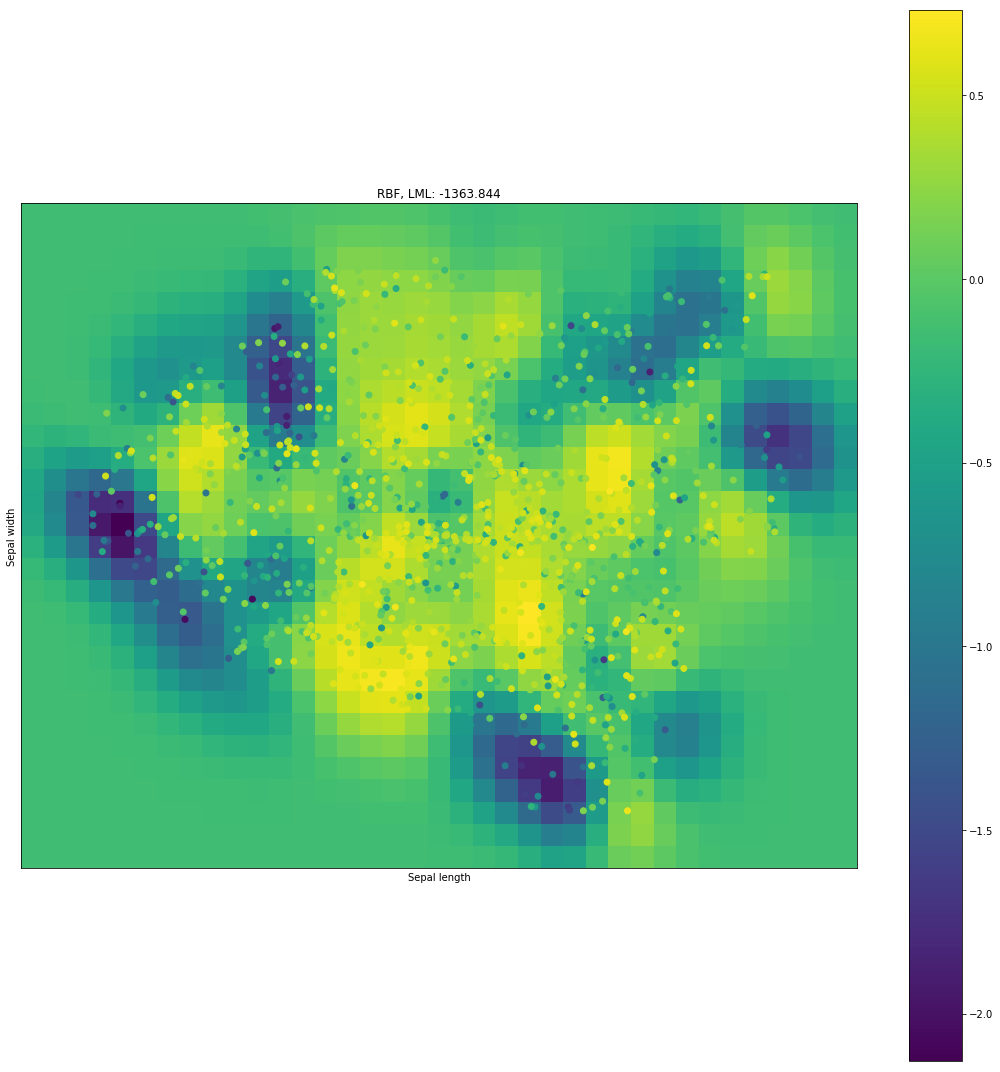

In [101]:
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 0.05, X[:, 0].max() + 0.05
y_min, y_max = X[:, 1].min() - 0.05, X[:, 1].max() + 0.05

h = .02  # step size in the mesh

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

plt.figure(figsize=(15, 15))
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")
plt.colorbar()

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=np.squeeze(y))
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xticks(())
plt.yticks(())
plt.title("%s, LML: %.3f" %
          ("RBF", gp.log_marginal_likelihood(gp.kernel_.theta)))

plt.tight_layout()
plt.show()

In [20]:
Data1['Predict'] = np.squeeze(gp.predict(X))

In [287]:
print('{}% of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location'.format(len(Data1[(Data1['AvgDailyTrafficCount']>(Data1['Predict']+2*Data1['Predict'].std()))|(Data1['AvgDailyTrafficCount']<(Data1['Predict']-2*Data1['Predict'].std()))])/float(len(Data1))))

0.117488789238% of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location


In [80]:
Data1['label'][Data1[Data1['AvgDailyTrafficCount']>(Data1['Predict']+2*Data1['Predict'].std())].index] = 'more than two standard deviations higher than predicted'
Data1['label'][Data1[(Data1['AvgDailyTrafficCount']<(Data1['Predict']+2*Data1['Predict'].std()))&(Data1['AvgDailyTrafficCount']>(Data1['Predict']-2*Data1['Predict'].std()))].index] = 'within two standard deviations of the predicted values'
Data1['label'][Data1[Data1['AvgDailyTrafficCount']<(Data1['Predict']-2*Data1['Predict'].std())].index] = 'more then two standard deviations lower than predicted'                                                               

C:\Users\Administrator\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Administrator\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Administrator\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports u

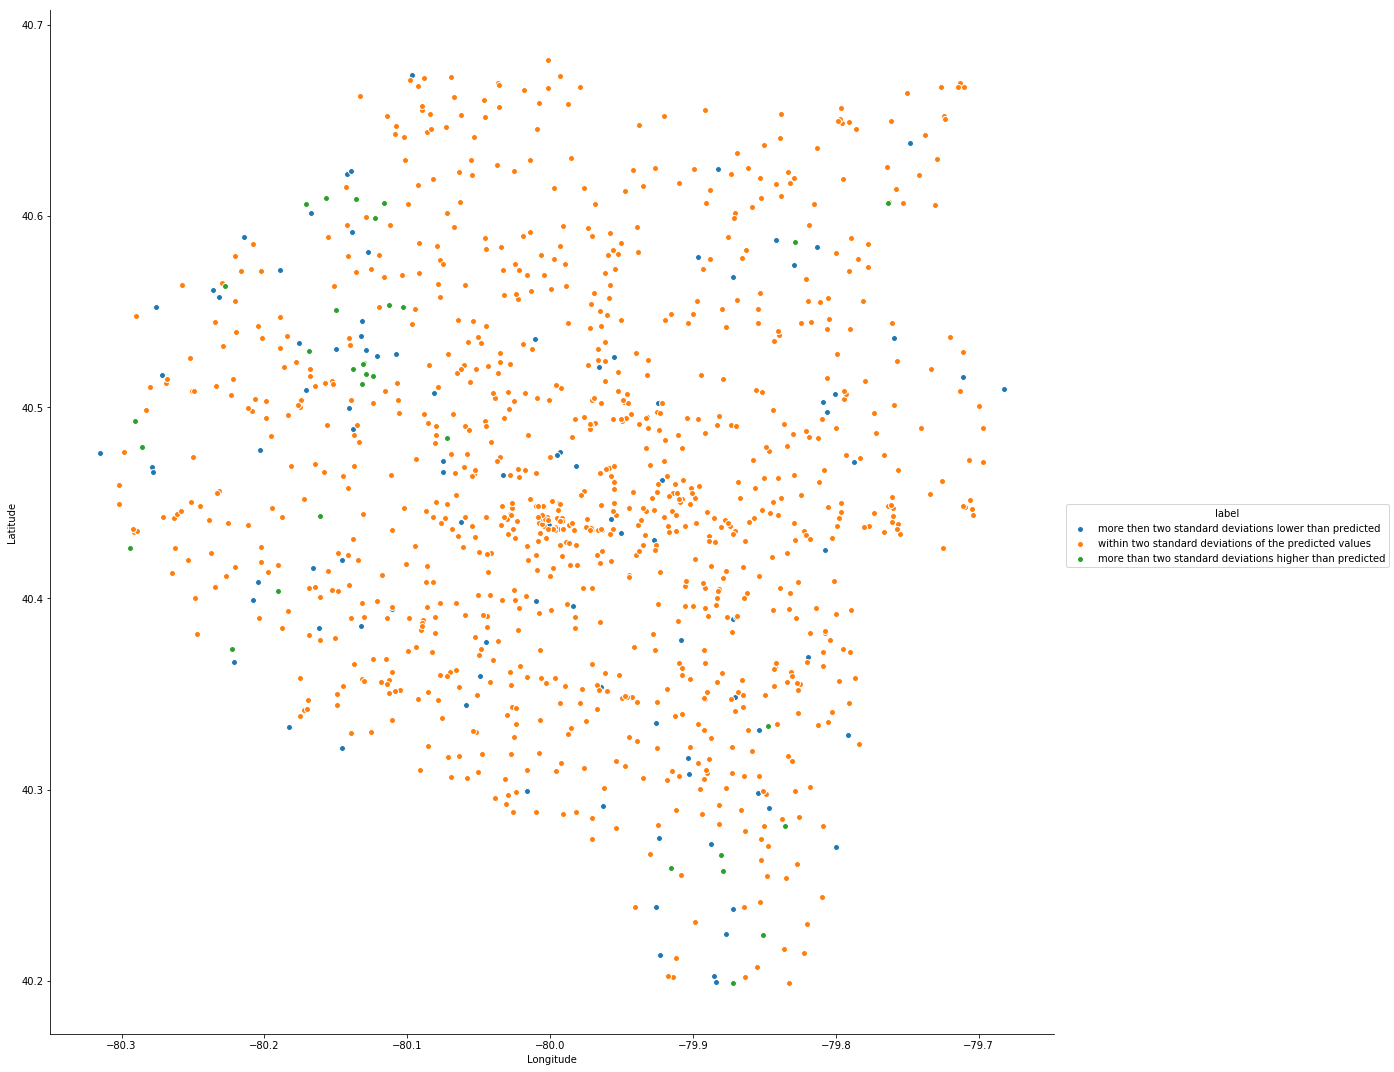

In [332]:
sns.pairplot(x_vars=['Longitude'], y_vars=['Latitude'], data=Data1, hue="label", size=15)

### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		Anomaly / Not Anomaly


(35, 2)		Anomaly / Not Anomaly


(15, 19)	Anomaly / Not Anomaly


(10, 11)	Anomaly / Not Anomaly


### Since the dataset is not claimed to be clean and there are only two points in C, which is smaller than the number of clusters 4, then the cluster C itself could be regarded as an anomaly 

In [140]:
def dis(p1,p2):
    return ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**0.5

In [146]:
def get_matrix(points,centers,std):
    data = pd.DataFrame(np.zeros([len(points),len(centers)]))
    for i in range(len(points)):
        for j in range(len(centers)):
            data.iloc[i,j] = dis(points[i],centers[j])
    data['cluster'] = np.argmin(np.array(data),1)
    data['inside'] = 0
    for i in range(len(points)):
        data['inside'][i] = True if data.iloc[i,data['cluster'][i]] <= std[data['cluster'][i]] else False
    return data

In [147]:
a = np.array([1,0])
b = np.array([35,2])
c = np.array([15,19])
d = np.array([10,11])
C1 = np.array([0,0])
C2 = np.array([35,5])
C4 = np.array([10,10])
points = [a,b,c,d]
centers = [C1,C2,C4]
std = [0.1,5,1]

In [149]:
get_matrix(points,centers,std)

C:\Users\Administrator\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,0,1,2,cluster,inside
0,1.000000,34.365681,13.453624,0,0
1,35.057096,3.000000,26.248809,1,1
2,24.207437,24.413111,10.295630,2,0
3,14.866069,25.709920,1.000000,2,1


(1, 0)		Anomaly


(35, 2)		Not Anomaly 


(15, 19)	Anomaly


(10, 11)	Not Anomaly 

### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [425]:
Data2=pd.read_csv("2016CountyHealthIndicators.csv")
Data2.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,...,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,...,20,4.5,28,12.0,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,...,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,...,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,...,24,4.1,28,8.5,219,89,12.7,12,85,59


In [426]:
# your code here
for col in Data2.columns[1:]:
    Data2[col] = pd.to_numeric(Data2[col],errors='coerce',downcast='float')

In [427]:
Data2 = Data2.dropna()

## Part1

In [428]:
df1 = Data2[["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"]]

In [429]:
for col in df1.columns:
    df1[col] = pd.cut(df1[col],5,labels=[0,1,2,3,4]).astype('int64')
df1.columns = [x.replace('\% ','').replace("'",'').replace(' ','_') for x in df1.columns]

C:\Users\Administrator\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [430]:
hc = HillClimbSearch(df1, scoring_method=BicScore(df1))
best_model = hc.estimate()
print((best_model.edges()))

[('Children_in_Poverty', 'Violent_Crime_Rate'), ('Children_in_Poverty', 'Smokers'), ('Smokers', 'Obese'), ('Smokers', 'Average_Daily_PM2.5'), ('80/20_Income_Ratio', 'Children_in_Poverty')]


In [431]:
model = model = BayesianModel(best_model.edges())
model.fit(df1, estimator=MaximumLikelihoodEstimator)

In [432]:
# Log-likelihood of data record x given model
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print thevariable,theparents,theprob
        loglike += np.log(theprob)
    return loglike

In [433]:
exmp=df1.apply(lambda x: LL(x,model),axis=1)

In [434]:
pd.DataFrame({'County':Data2.iloc[exmp.sort_values().head().index]['County'],'log-likelihood':exmp.sort_values().head().values})

,County,log-likelihood
2343,"Laurens, South Carolina",-16.608495
277,"Larimer, Colorado",-14.827149
2576,"Dallam, Texas",-14.686742
1508,"Crawford, Missouri",-14.457849
386,"Atkinson, Georgia",-13.671439


In [463]:
Data2['Beyas'] = list(exmp)

## Type2

In [435]:
KM=KMeans(n_clusters=3,random_state=999)
scor=KM.fit_predict(Data2.iloc[:,1:])

# distance to each cluster center
res=pd.DataFrame(KM.transform(Data2.iloc[:,1:]))
res.head()

,0,1,2
0,215.546368,554.609617,101.895485
1,108.370262,655.932344,186.335226
2,410.503731,530.643663,282.291939
3,168.209200,602.378878,141.457457
4,105.075152,777.335076,315.009861


In [436]:
# add cluster and distance information for each data record
res=pd.DataFrame(KM.transform(Data2.iloc[:,1:]))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(Data2.iloc[:,1:]))),axis=1)
res.columns=list(range(3))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

# find data records farthest from cluster centers
res.sort_values("score",ascending=False)[:5]

,0,1,2,cluster,score
1890,2443.716031,1970.018443,2251.260167,1,1970.018443
1294,2036.147297,1332.735955,1759.249198,1,1332.735955
96,1917.732820,1208.900834,1639.063836,1,1208.900834
2304,1644.876605,1017.910163,1394.632068,1,1017.910163
995,1651.954082,918.374430,1366.737248,1,918.374430


In [439]:
Data2['km_score'] = list(res.score)

In [441]:
GM=GaussianMixture(n_components=3,random_state=999)
GM.fit(Data2.iloc[:,1:])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=999, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [442]:
Data2.insert(0,'GM',GM.score_samples(Data2.iloc[:,1:]))

In [443]:
Data2.sort_values(by='GM').head()

,GM,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive',...,'80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone',km_score
2415,-213.093594,"Shannon, South Dakota",33.0,5.9,4.7,7.0,41.0,45.0,1.6,24.0,...,6.5,68.0,2.8,0.0,200.0,11.8,44.0,64.0,22.0,1970.018443
108,-138.259208,"Yuma, Arizona",24.0,4.1,3.9,6.0,15.0,30.0,5.2,28.0,...,4.1,32.0,4.3,352.0,53.0,9.9,21.0,78.0,19.0,41.494999
2765,-135.509295,"Willacy, Texas",37.0,5.2,3.6,9.0,20.0,29.0,7.3,27.0,...,6.8,43.0,5.9,902.0,47.0,8.7,18.0,90.0,27.0,463.627032
94,-134.665509,"Apache, Arizona",30.0,5.7,5.3,7.0,26.0,33.0,0.5,22.0,...,6.3,52.0,3.5,94.0,173.0,9.8,36.0,75.0,42.0,478.265904
1856,-134.587525,"New York, New York",14.0,3.5,3.5,9.0,13.0,15.0,7.8,18.0,...,8.7,41.0,13.0,620.0,32.0,10.8,25.0,6.0,63.0,155.756157


## Part 3

In [444]:
from sklearn.ensemble import IsolationForest
from scipy import stats  
ilf = IsolationForest(n_estimators=100,
                      n_jobs=-1,        
                      verbose=2)

In [445]:
X_cols = Data2.columns[2:]

In [446]:
ilf.fit(Data2[X_cols])
shape = Data2.shape[0]
batch = 10**6
all_score = []
all_pred = []
for i in range(shape/batch+1):
    start = i * batch
    end = (i+1) * batch
    test = Data2[X_cols][start:end]
    
    pred = ilf.predict(test)
    score = ilf.decision_function(test)
    all_pred.extend(pred)
    all_score.extend(score)
Data2['pred_ilf'] = all_pred
Data2['score_ilf'] = all_score

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.0s remaining:    8.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.9s finished


In [447]:
Data2.sort_values(by='score_ilf',ascending=True).head()

,GM,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive',...,'Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone',km_score,pred_ilf,score_ilf
2415,-213.093594,"Shannon, South Dakota",33.0,5.9,4.7,7.0,41.0,45.0,1.6,24.0,...,2.8,0.0,200.0,11.8,44.0,64.0,22.0,1970.018443,-1,-0.188819
94,-134.665509,"Apache, Arizona",30.0,5.7,5.3,7.0,26.0,33.0,0.5,22.0,...,3.5,94.0,173.0,9.8,36.0,75.0,42.0,478.265904,-1,-0.123254
65,-112.884327,"Wilcox, Alabama",34.0,6.0,5.4,14.0,25.0,44.0,1.8,32.0,...,8.8,216.0,104.0,12.9,20.0,85.0,25.0,773.253831,-1,-0.122711
1128,-116.776459,"East Carroll, Louisiana",38.0,6.1,5.1,15.0,33.0,43.0,4.0,37.0,...,10.6,662.0,73.0,12.0,20.0,88.0,14.0,212.277759,-1,-0.117088
1412,-105.361025,"Coahoma, Mississippi",28.0,4.8,4.5,19.0,25.0,46.0,2.5,38.0,...,9.5,717.0,114.0,12.2,20.0,77.0,18.0,581.211194,-1,-0.109875


In [454]:
Data2.sort_values(by='km_score',ascending=False).head() #based on kmeans

,GM,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive',...,'Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone',km_score,pred_ilf,score_ilf
2415,-213.093594,"Shannon, South Dakota",33.0,5.9,4.7,7.0,41.0,45.0,1.6,24.0,...,2.8,0.0,200.0,11.8,44.0,64.0,22.0,1970.018443,-1,-0.188819
1595,-122.615721,"St. Louis City, Missouri",23.0,5.0,4.4,12.0,26.0,32.0,5.0,25.0,...,14.1,1885.0,98.0,11.9,23.0,71.0,25.0,1332.735955,-1,-0.062528
126,-117.093111,"Crittenden, Arkansas",26.0,5.2,4.6,13.0,26.0,38.0,4.8,34.0,...,8.2,1764.0,65.0,12.7,20.0,83.0,31.0,1208.900834,-1,-0.046215
2939,-111.244844,"Petersburg City, Virginia",26.0,4.5,4.0,13.0,23.0,38.0,4.4,28.0,...,16.6,560.0,81.0,12.3,18.0,79.0,23.0,1017.910163,-1,-0.026059
1214,-103.930479,"Baltimore City, Maryland",20.0,3.8,3.9,12.0,21.0,34.0,6.0,29.0,...,9.7,1449.0,99.0,12.6,24.0,60.0,39.0,918.374430,-1,-0.051151


In [449]:
Data2.sort_values(by='GM').head() #based on GM

,GM,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive',...,'Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone',km_score,pred_ilf,score_ilf
2415,-213.093594,"Shannon, South Dakota",33.0,5.9,4.7,7.0,41.0,45.0,1.6,24.0,...,2.8,0.0,200.0,11.8,44.0,64.0,22.0,1970.018443,-1,-0.188819
108,-138.259208,"Yuma, Arizona",24.0,4.1,3.9,6.0,15.0,30.0,5.2,28.0,...,4.3,352.0,53.0,9.9,21.0,78.0,19.0,41.494999,1,0.034368
2765,-135.509295,"Willacy, Texas",37.0,5.2,3.6,9.0,20.0,29.0,7.3,27.0,...,5.9,902.0,47.0,8.7,18.0,90.0,27.0,463.627032,-1,-0.059771
94,-134.665509,"Apache, Arizona",30.0,5.7,5.3,7.0,26.0,33.0,0.5,22.0,...,3.5,94.0,173.0,9.8,36.0,75.0,42.0,478.265904,-1,-0.123254
1856,-134.587525,"New York, New York",14.0,3.5,3.5,9.0,13.0,15.0,7.8,18.0,...,13.0,620.0,32.0,10.8,25.0,6.0,63.0,155.756157,-1,-0.041613


In [468]:
Data2.sort_values(by='Beyas').head() #based on bayes

,GM,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive',...,'Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone',km_score,pred_ilf,score_ilf,Beyas
1856,-134.587525,"New York, New York",14.0,3.5,3.5,9.0,13.0,15.0,7.8,18.0,...,620.0,32.0,10.8,25.0,6.0,63.0,155.756157,-1,-0.041613,-16.608495
221,-105.391176,"San Francisco, California",11.0,3.2,3.1,7.0,12.0,15.0,7.3,14.0,...,703.0,55.0,8.0,27.0,36.0,46.0,216.728121,-1,-0.015932,-14.827149
2027,-132.780474,"Rolette, North Dakota",29.0,5.1,4.5,10.0,38.0,41.0,6.9,34.0,...,29.0,104.0,9.6,21.0,84.0,14.0,742.821948,-1,-0.109250,-14.686742
1227,-112.185819,"Suffolk, Massachusetts",16.0,3.5,3.8,9.0,15.0,21.0,7.6,20.0,...,910.0,46.0,10.4,26.0,41.0,46.0,276.060105,-1,-0.047228,-14.457849
317,-117.678095,"District of Columbia, District of Columbia",13.0,2.8,3.2,10.0,16.0,22.0,8.0,17.0,...,1259.0,58.0,12.7,22.0,34.0,44.0,651.326422,-1,-0.095171,-13.671439


In [477]:
Data2[(Data2['GM']*Data2['Beyas']*Data2['score_ilf']>0)&(Data2['GM']<-90)&(Data2['score_ilf']>0.11)]

,GM,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive',...,'Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone',km_score,pred_ilf,score_ilf,Beyas
493,-93.111210,"Oglethorpe, Georgia",15.0,3.5,3.6,8.0,15.0,30.0,7.8,27.0,...,384.0,65.0,13.1,10.0,85.0,43.0,241.425015,1,0.112685,-4.537242
1139,-91.079255,"Lafourche, Louisiana",19.0,4.0,3.9,9.0,20.0,36.0,7.7,34.0,...,171.0,70.0,11.9,14.0,78.0,36.0,180.668972,1,0.113373,-4.428545
1539,-93.866323,"Livingston, Missouri",15.0,3.9,3.8,8.0,20.0,28.0,7.3,29.0,...,180.0,62.0,9.3,12.0,82.0,17.0,176.090298,1,0.112747,-4.379692
1745,-90.952950,"Churchill, Nevada",17.0,4.2,3.8,7.0,18.0,29.0,7.1,24.0,...,190.0,87.0,12.7,11.0,82.0,12.0,90.387269,1,0.110915,-2.861787


## We can see that there are some counties above found to be anomalous in GM model but not in isolation forest model

In [481]:
set(Data2.sort_values(by='GM').index[:20]) & set(Data2.sort_values(by='score_ilf',ascending=True).index[:20]) & set(Data2.sort_values(by='km_score',ascending=False).index[:20]) & set(Data2.sort_values(by='Beyas').index[:100])

{2027, 2415}

In [480]:
Data2.loc[[2027,2415]]

,GM,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive',...,'Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone',km_score,pred_ilf,score_ilf,Beyas
2027,-132.780474,"Rolette, North Dakota",29.0,5.1,4.5,10.0,38.0,41.0,6.9,34.0,...,29.0,104.0,9.6,21.0,84.0,14.0,742.821948,-1,-0.109250,-14.686742
2415,-213.093594,"Shannon, South Dakota",33.0,5.9,4.7,7.0,41.0,45.0,1.6,24.0,...,0.0,200.0,11.8,44.0,64.0,22.0,1970.018443,-1,-0.188819,-10.856363


## These two counties were found to be anomalous in all of the three models. After observation, I found that their [Reporting Fair/Poor Health], [Physically Unhealthy Days Per Month], [% Smokers], [% Obese], [Injury Death Rate], [Severe Housing Problems] are relatively high and their [Violent Crime Rate], [Long Commute Drives Alone] are relatively low